In [77]:
# Data Processing
import pandas as pd
import numpy as np

# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

# Bayesian
# ==============================================================================
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RepeatedStratifiedKFold,StratifiedKFold
from sklearn.metrics import classification_report
import xgboost as xgb
from collections import Counter
import time
import optuna
from optuna.samplers import TPESampler
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score

# Bayesian Multiobjetivo
# ==============================================================================
import pickle
import sys
import warnings

from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [57]:
#carga los datos
tabla_final = pd.read_csv('correlaciones/tabla_entrega_final.csv', sep = ",")

## Definimos una tabla con los id de clientes
## Para luego poeder funtarla con las prob ##
## Si se queda se considera como parametro ##
tabla_con_id_cliente = tabla_final

tabla_final = tabla_final.drop('ID_CLIENTE', axis=1)
#visualizamos los datos
tabla_final

,ANTIGUEDAD,FLAG_ACTIVI,ID_ESTADO,ACEPTADO,CT_CTE,DEBITO_DIR,Suma,RENTA,EDAD,ID_GENERO,ID_REGION_RESIDE
0,6.0,1.0,0.0,0.0,1,0,1,87218.10,36.0,1.0,0.0
1,35.0,0.0,1.0,0.0,1,0,1,122179.11,23.0,0.0,0.0
2,35.0,0.0,1.0,0.0,0,0,1,119775.54,23.0,1.0,0.0
3,35.0,0.0,1.0,0.0,1,0,1,22220.04,24.0,1.0,0.0
4,35.0,0.0,1.0,0.0,1,0,1,295590.36,24.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
602519,62.0,0.0,1.0,0.0,0,0,0,97397.16,41.0,1.0,1.0
602520,7.0,0.0,1.0,0.0,0,0,0,168445.62,34.0,0.0,0.0
602521,6.0,0.0,1.0,0.0,0,0,0,53689.02,24.0,1.0,1.0
602522,229.0,0.0,1.0,0.0,0,0,0,64404.21,61.0,0.0,0.0


In [63]:
# Split the data into features (X) and target (y)
X = tabla_final.drop('ACEPTADO', axis=1)
y = tabla_final['ACEPTADO']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [65]:
len(y_train[y_train == 1]) / len(y_train)

0.07348465516919457

In [67]:
# Bayesian Multiobjetivo
# ==============================================================================
def train(trial):
    
    max_depth = trial.suggest_int('max_depth', 5, X_train.shape[1]) #profundidad máxima del árbol
    n_estimators=trial.suggest_int('n_estimators',125, 200) #número de ramas en el árbol
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20) #mínimo de muestras en el nodo para que se pueda dividir
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 20) #mínimo de muestras en un nodo para que sea considerado una hoja
    min_impurity_decrease  = trial.suggest_float('min_impurity_decrease', 0, 1) #mínimo para supervisar si es necesario separar un nodo.
    
    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("model", RandomForestClassifier(max_depth = max_depth, n_estimators = n_estimators, min_samples_split= min_samples_split, min_samples_leaf=min_samples_leaf, min_impurity_decrease=min_impurity_decrease, class_weight='balanced', random_state=22))
    ])
    
    pipeline.fit(X_train, y_train)
    score = cross_val_score(pipeline, X_train, y_train, scoring='accuracy',
                            cv=4).mean()
    y_pred = pipeline.predict(X_test)
    recall = recall_score(y_test, y_pred)
    

    return score, recall


motpe_sampler = optuna.samplers.MOTPESampler()
motpe_experiment = optuna.create_study(sampler=motpe_sampler, directions=['maximize', 'maximize'])
motpe_experiment.optimize(train, n_trials=20)

/var/folders/cc/3mg7xtb906vcdzf2brdmqt500000gn/T/ipykernel_4473/1113040092.py:26: FutureWarning: MOTPESampler has been deprecated in v2.9.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.9.0.
  motpe_sampler = optuna.samplers.MOTPESampler()
[I 2023-06-26 00:12:10,781] A new study created in memory with name: no-name-be5840fc-7722-46a1-a7bd-5f35ff7f90cc
[I 2023-06-26 00:12:54,332] Trial 0 finished with values: [0.8836415165615233, 0.8362507058159232] and parameters: {'max_depth': 6, 'n_estimators': 137, 'min_samples_split': 11, 'min_samples_leaf': 13, 'min_impurity_decrease': 0.07676861730452733}. 
[I 2023-06-26 00:13:39,879] Trial 1 finished with values: [0.8836560389010307, 0.8372670807453416] and parameters: {'max_depth': 10, 'n_estimators': 142, 'min_samples_split': 11, 'min_samples_leaf': 5, 'min_impurity_decrease': 0.048253826319563875}. 
[I 2023-06-26 00:14:11,928] Trial 2 finished with values: [0.2867431362121117, 0.0] and parameter

In [68]:
def cast_as_df(optuna_experiment, experiment_type):
    df = (
        optuna_experiment
        .trials_dataframe()
        .rename(columns={"values_0": "accuracy", "values_1": "sensibilidad"})
        .assign(experiment = experiment_type)
    )
    # the following lines create a column identifing which of the trials resulted in a
    # Best configuration -- a model with these HPs lies along the empirical Pareto frontier
    best_trials = [trial.number for trial in optuna_experiment.best_trials]
    df['best_trial'] = np.where(df.number.isin(best_trials), 1, 0)
    return df

motpe_df = cast_as_df(motpe_experiment, "MOTPE")
motpe_df

,number,accuracy,sensibilidad,datetime_start,datetime_complete,duration,params_max_depth,params_min_impurity_decrease,params_min_samples_leaf,params_min_samples_split,params_n_estimators,state,experiment,best_trial
0,0,0.883642,0.836251,2023-06-26 00:12:10.782526,2023-06-26 00:12:54.332346,0 days 00:00:43.549820,6,0.076769,13,11,137,COMPLETE,MOTPE,0
1,1,0.883656,0.837267,2023-06-26 00:12:54.334020,2023-06-26 00:13:39.879636,0 days 00:00:45.545616,10,0.048254,5,11,142,COMPLETE,MOTPE,1
2,2,0.286743,0.000000,2023-06-26 00:13:39.881110,2023-06-26 00:14:11.927951,0 days 00:00:32.046841,10,0.644911,12,3,158,COMPLETE,MOTPE,0
3,3,0.901213,0.816714,2023-06-26 00:14:11.929425,2023-06-26 00:14:52.597599,0 days 00:00:40.668174,6,0.253224,6,20,179,COMPLETE,MOTPE,1
4,4,0.073485,0.000000,2023-06-26 00:14:52.598348,2023-06-26 00:15:17.613942,0 days 00:00:25.015594,8,0.788880,7,15,127,COMPLETE,MOTPE,0
5,5,0.499998,0.000000,2023-06-26 00:15:17.614475,2023-06-26 00:15:50.781516,0 days 00:00:33.167041,7,0.572479,11,2,165,COMPLETE,MOTPE,0
6,6,0.499998,0.000000,2023-06-26 00:15:50.783169,2023-06-26 00:16:25.382934,0 days 00:00:34.599765,5,0.657328,12,7,168,COMPLETE,MOTPE,0
7,7,0.875652,0.839300,2023-06-26 00:16:25.384612,2023-06-26 00:17:02.489270,0 days 00:00:37.104658,9,0.162525,6,16,133,COMPLETE,MOTPE,1
8,8,0.073485,0.000000,2023-06-26 00:17:02.489875,2023-06-26 00:17:33.200233,0 days 00:00:30.710358,7,0.413010,15,5,154,COMPLETE,MOTPE,0
9,9,0.286743,0.000000,2023-06-26 00:17:33.201746,2023-06-26 00:18:03.497029,0 days 00:00:30.295283,7,0.520779,18,13,155,COMPLETE,MOTPE,0


In [69]:
df_final = motpe_df[motpe_df['best_trial'] == 1]
df_final

,number,accuracy,sensibilidad,datetime_start,datetime_complete,duration,params_max_depth,params_min_impurity_decrease,params_min_samples_leaf,params_min_samples_split,params_n_estimators,state,experiment,best_trial
1,1,0.883656,0.837267,2023-06-26 00:12:54.334020,2023-06-26 00:13:39.879636,0 days 00:00:45.545616,10,0.048254,5,11,142,COMPLETE,MOTPE,1
3,3,0.901213,0.816714,2023-06-26 00:14:11.929425,2023-06-26 00:14:52.597599,0 days 00:00:40.668174,6,0.253224,6,20,179,COMPLETE,MOTPE,1
7,7,0.875652,0.839300,2023-06-26 00:16:25.384612,2023-06-26 00:17:02.489270,0 days 00:00:37.104658,9,0.162525,6,16,133,COMPLETE,MOTPE,1
10,10,0.883874,0.836138,2023-06-26 00:18:03.497607,2023-06-26 00:19:04.204492,0 days 00:01:00.706885,10,0.064174,3,8,198,COMPLETE,MOTPE,1
15,15,0.675395,0.979334,2023-06-26 00:21:24.204976,2023-06-26 00:21:57.783640,0 days 00:00:33.578664,5,0.182166,9,13,127,COMPLETE,MOTPE,1
16,16,0.841759,0.899944,2023-06-26 00:21:57.784300,2023-06-26 00:23:13.111404,0 days 00:01:15.327104,8,0.007711,15,5,197,COMPLETE,MOTPE,1
18,18,0.901213,0.816714,2023-06-26 00:23:54.030652,2023-06-26 00:24:37.745070,0 days 00:00:43.714418,8,0.227159,15,5,189,COMPLETE,MOTPE,1


In [70]:
best_value = df_final.loc[df_final['sensibilidad'].idxmax()]
pd.DataFrame(best_value)  

,15
number,15
accuracy,0.675395
sensibilidad,0.979334
datetime_start,2023-06-26 00:21:24.204976
datetime_complete,2023-06-26 00:21:57.783640
duration,0 days 00:00:33.578664
params_max_depth,5
params_min_impurity_decrease,0.182166
params_min_samples_leaf,9
params_min_samples_split,13


In [72]:
##### Caso con parametros optimos ####

best_rf = RandomForestClassifier(max_depth = best_value['params_max_depth'],n_estimators = best_value['params_n_estimators'], min_samples_split= best_value['params_min_samples_split'], min_samples_leaf=best_value['params_min_samples_leaf'], min_impurity_decrease=best_value['params_min_impurity_decrease'], class_weight='balanced', random_state=22)
best_rf.fit(X_train, y_train)
y_pred = best_rf.predict(X_test)

In [73]:
#### Indicadores de desempeño ###

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

### CON ID CLIENTE ###
#Accuracy: 0.9387741500729408
#Precision: 0.6155514767228433
#Recall: 0.3821609862218999

### CON TABLA ANTIGUA SIN FILTROS ###
#Accuracy: 0.9370191275242333
#Precision: 0.6259222333000997
#Recall: 0.32135544635544633

Accuracy: 0.6748101738517074
Precision: 0.18189445423273765
Recall: 0.9793337097684923


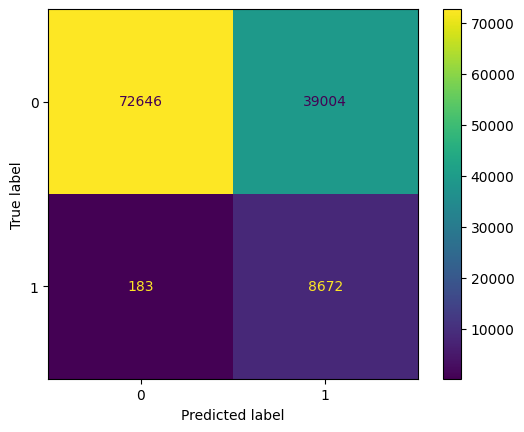

In [74]:
# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot()

<Axes: >

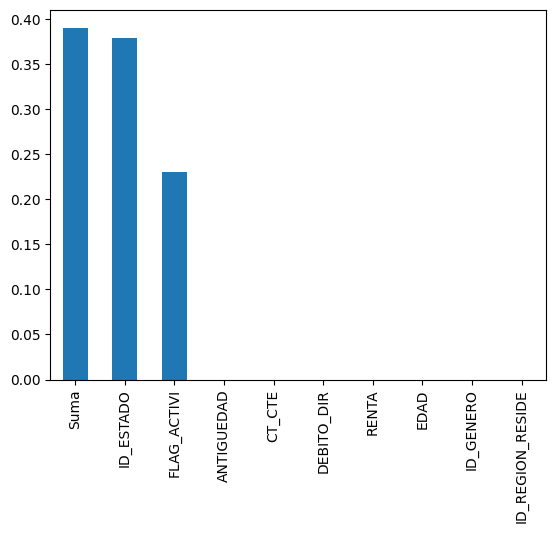

In [75]:
# Create a series containing feature importances from the model and feature names from the training data
feature_importances = pd.Series(best_rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Plot a simple bar chart
feature_importances.plot.bar()

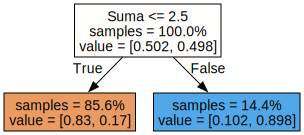

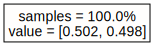

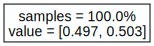

In [79]:
# Export the first three decision trees from the forest

for i in range(3):
    tree = best_rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=X_train.columns,  
                               filled=True,  
                               max_depth=2, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

In [87]:
predicciones = best_rf.predict_proba(X)
len(predicciones)

602524

In [88]:
df_predicciones = pd.DataFrame(predicciones)
df_predicciones_aceptar = df_predicciones[1]

In [89]:
tabla_con_id_cliente_mas_probabilidad = pd.merge(tabla_con_id_cliente, df_predicciones_aceptar, left_index=True, right_index=True)

tabla_con_id_cliente_mas_probabilidad

,ID_CLIENTE,ANTIGUEDAD,FLAG_ACTIVI,ID_ESTADO,ACEPTADO,CT_CTE,DEBITO_DIR,Suma,RENTA,EDAD,ID_GENERO,ID_REGION_RESIDE,1
0,1375586.0,6.0,1.0,0.0,0.0,1,0,1,87218.10,36.0,1.0,0.0,0.502670
1,1050612.0,35.0,0.0,1.0,0.0,1,0,1,122179.11,23.0,0.0,0.0,0.212287
2,1050613.0,35.0,0.0,1.0,0.0,0,0,1,119775.54,23.0,1.0,0.0,0.212287
3,1050615.0,35.0,0.0,1.0,0.0,1,0,1,22220.04,24.0,1.0,0.0,0.212287
4,1050616.0,35.0,0.0,1.0,0.0,1,0,1,295590.36,24.0,1.0,0.0,0.212287
...,...,...,...,...,...,...,...,...,...,...,...,...,...
602519,899549.0,62.0,0.0,1.0,0.0,0,0,0,97397.16,41.0,1.0,1.0,0.212287
602520,1441442.0,7.0,0.0,1.0,0.0,0,0,0,168445.62,34.0,0.0,0.0,0.212287
602521,1454431.0,6.0,0.0,1.0,0.0,0,0,0,53689.02,24.0,1.0,1.0,0.212287
602522,56812.0,229.0,0.0,1.0,0.0,0,0,0,64404.21,61.0,0.0,0.0,0.212287


In [92]:
tabla_con_id_cliente_mas_probabilidad = tabla_con_id_cliente_mas_probabilidad.sort_values(by=1, ascending = False)
tabla_con_id_cliente_mas_probabilidad.dropna()

,ID_CLIENTE,ANTIGUEDAD,FLAG_ACTIVI,ID_ESTADO,ACEPTADO,CT_CTE,DEBITO_DIR,Suma,RENTA,EDAD,ID_GENERO,ID_REGION_RESIDE,1
238068,386607.0,153.0,1.0,0.0,1.0,0,1,9,107852.22,33.0,0.0,0.0,0.696920
186783,1224517.0,17.0,1.0,0.0,0.0,0,1,4,44031.18,31.0,0.0,0.0,0.696920
245842,392769.0,152.0,1.0,0.0,1.0,0,1,6,117614.43,63.0,0.0,1.0,0.696920
186787,1224526.0,20.0,1.0,0.0,0.0,0,1,5,38434.02,51.0,0.0,0.0,0.696920
379567,437273.0,142.0,1.0,0.0,1.0,1,1,3,113129.13,44.0,0.0,1.0,0.696920
...,...,...,...,...,...,...,...,...,...,...,...,...,...
267751,116303.0,199.0,0.0,1.0,0.0,1,0,1,80922.45,58.0,0.0,0.0,0.212287
267742,116406.0,172.0,0.0,1.0,0.0,0,0,1,86071.86,43.0,1.0,1.0,0.212287
267733,116459.0,198.0,0.0,1.0,0.0,1,0,1,109762.23,58.0,0.0,1.0,0.212287
267724,116338.0,199.0,0.0,1.0,0.0,0,0,0,156558.96,59.0,0.0,1.0,0.212287


In [93]:
tabla_con_id_cliente_mas_probabilidad.to_csv(r'resultados_modelos\Resultados_Random_Forest.csv', index=False, header=True)